# LOS Prediction - Basic Linear Regression with Regularization

This notebook explores fitting the 24 or 48 hour data set using linear regression with SGD

In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

import numpy as np

print(tf.__version__)

2.0.0


In [65]:

raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first24hours.csv', header=0)
df = raw_dataset.copy()

df = df.loc[:, (df==0).mean() < .7]
df.fillna(0, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Heart Rate'] > 0]

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


,los,age,gender,insurance,language,religion,marital_status,ethnicity,Anion Gap,Anion Gap-trend,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3629,8.116,75.0516,M,Medicare,ENGL,NOT SPECIFIED,WIDOWED,WHITE,14.000,-0.047,...,0.000,0.000,4.357,0.038,58.474,0.231,0.000,0.000,0.0,0.0
3630,4.414,45.9942,F,Medicare,0,CATHOLIC,DIVORCED,WHITE,15.333,-0.377,...,92.800,-4.402,0.000,0.000,59.000,0.269,46.024,-1.299,0.0,0.0
3631,5.079,91.4000,F,Medicare,0,CATHOLIC,WIDOWED,WHITE,16.000,0.000,...,115.529,1.685,29.400,-1.532,58.794,-0.111,36.569,-0.060,0.0,0.0
3632,13.688,77.1680,M,Medicare,0,NOT SPECIFIED,MARRIED,WHITE,16.500,0.364,...,107.000,1.036,4.967,-0.733,62.565,-0.194,35.802,-0.012,0.0,0.0
3633,4.706,81.6527,F,Medicare,0,CATHOLIC,MARRIED,WHITE,17.000,-1.548,...,91.375,5.784,0.000,0.000,60.056,-0.090,42.919,0.586,0.0,0.0


In [66]:
# One hot encode the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    #df = df.join(one_hot)
df.tail()

,los,age,Anion Gap,Anion Gap-trend,Basophils,Bicarbonate,Bicarbonate-trend,Chloride,Chloride-trend,Creatinine,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3629,8.116,75.0516,14.000,-0.047,0.2,24.000,-0.181,106.0,0.181,0.767,...,0.000,0.000,4.357,0.038,58.474,0.231,0.000,0.000,0.0,0.0
3630,4.414,45.9942,15.333,-0.377,0.2,23.333,0.233,103.0,0.420,0.700,...,92.800,-4.402,0.000,0.000,59.000,0.269,46.024,-1.299,0.0,0.0
3631,5.079,91.4000,16.000,0.000,0.8,24.000,0.000,99.0,0.000,1.350,...,115.529,1.685,29.400,-1.532,58.794,-0.111,36.569,-0.060,0.0,0.0
3632,13.688,77.1680,16.500,0.364,0.2,21.000,-0.485,100.0,0.242,1.150,...,107.000,1.036,4.967,-0.733,62.565,-0.194,35.802,-0.012,0.0,0.0
3633,4.706,81.6527,17.000,-1.548,0.0,22.500,0.194,100.0,1.161,0.700,...,91.375,5.784,0.000,0.000,60.056,-0.090,42.919,0.586,0.0,0.0


In [67]:
train_dataset = df.sample(frac=0.7,random_state=0)
test_dataset = df.drop(train_dataset.index)


In [68]:
train_stats = train_dataset.describe()
train_stats.pop("los")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,2544.0,65.796918,18.747812,0.000,54.46250,68.53265,80.38230,91.400
Anion Gap,2544.0,14.436974,3.638170,0.000,12.33300,14.33300,16.50000,36.200
Anion Gap-trend,2544.0,-0.111654,0.310102,-2.675,-0.23900,-0.08400,0.00000,6.000
Basophils,2544.0,0.221124,0.356164,0.000,0.00000,0.10000,0.30000,9.667
Bicarbonate,2544.0,24.725947,5.876408,0.000,21.50000,24.50000,27.50000,51.000
Bicarbonate-trend,2544.0,-0.049011,0.268682,-2.609,-0.17300,0.00000,0.08000,2.500
Chloride,2544.0,102.161811,12.288226,0.000,99.50000,103.00000,107.00000,140.000
Chloride-trend,2544.0,0.204083,0.363275,-2.163,0.00000,0.14500,0.36425,3.158
Creatinine,2544.0,1.456512,1.548185,0.000,0.70000,1.00000,1.55000,22.700
Creatinine-trend,2544.0,-0.007507,0.030679,-0.354,-0.01500,-0.00400,0.00000,0.136


In [69]:
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


10.566475784259769
7.882999999999999


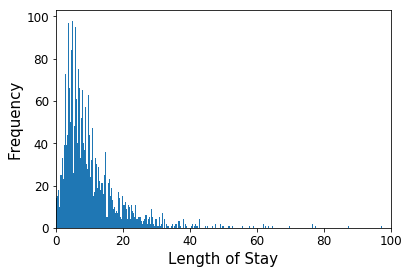

In [70]:
# LOS histogram

df['los'].hist(bins=1000, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Length of Stay", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,100.0])

print(df['los'].mean())
print(df['los'].median())


In [75]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from math import sqrt

X_train, X_val, y_train, y_val = train_test_split(normed_train_data, train_labels, test_size=0.70)

# normed_train_data

clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
# clf = LinearRegression(normalize=True)
clf.fit(X_train, y_train)

y_train_preds = clf.predict(X_train)
training_error = mean_absolute_error(y_train, y_train_preds)
print("Training (LOS): " + str(training_error))

y_val_preds = clf.predict(X_val)
training_error = mean_absolute_error(y_val, y_val_preds)
print("Validation (LOS): " + str(training_error))

y_test_preds = clf.predict(normed_test_data)
test_error = mean_absolute_error(test_labels, y_test_preds)
print("Testing (LOS): " + str(test_error))



Training (LOS): 5.684796442701616
Validation (LOS): 6.421051149456886
Testing (LOS): 6.512396709905563


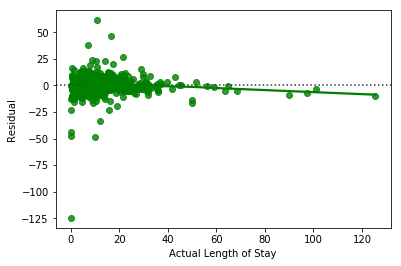

In [72]:
#np.subtract(y_train_preds, y_train)
#sns.residplot(y_train, np.subtract(y_train_preds, y_train), lowess=True, color="g")

ax = sns.residplot(test_labels, np.subtract(y_test_preds, test_labels), lowess=True, color="g")
ax.set(xlabel='Actual Length of Stay', ylabel='Residual')
plt.show()